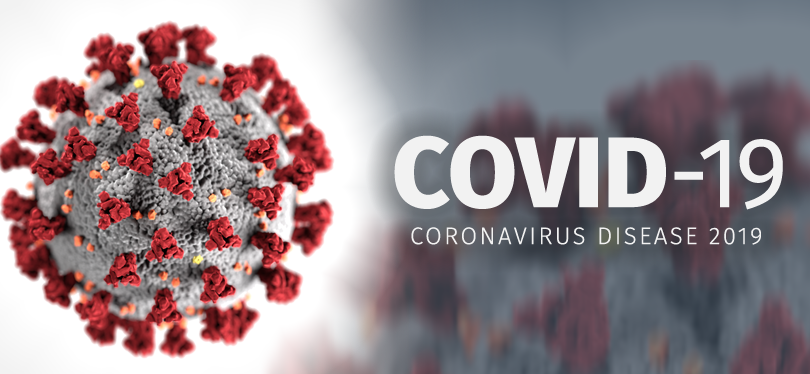

#      <center> COVID-19 Data Analysis and Forecasting: Algeria and the World </center>

### <center> Sami Belkacem, PhD Student in Artificial Intelligence, USTHB University </center>

# 1- Import libraries and define functions

In [1]:
import os
os.environ['PROJ_LIB'] = "...\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
from math import sqrt
from itertools import chain
from functools import reduce
from scipy.stats import zscore
from fbprophet import Prophet
from mpl_toolkits.basemap import Basemap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from matplotlib.legend_handler import HandlerLine2D
warnings.simplefilter('ignore', category=FutureWarning)

C:\Users\Sam\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

# 2- Read CSV files to dataframes

In [3]:
file_names = ["continents-latitude-longitude", "temperature", "hospital-beds-per-1000-people", 
              "medical-doctors-per-1000-people", "gdp-per-capita", "population", "age", "daily_tests_cases_deaths"]

dataframe_names = ["continent_lat_long", "temperature", "beds", "doctors", "gdp", "population", "age", "tests_cases_deaths"]

count = 0
for file_name in file_names:
    locals()["df_" + dataframe_names[count]] = pd.read_csv(root + file_name + ".csv", engine='python')
    count += 1

all_dataframes = [df_continent_lat_long, df_temperature, df_beds, df_doctors, df_gdp, df_population, df_age, df_tests_cases_deaths]

## Number of countries in each file

In [4]:
count = 0
for dataframe in all_dataframes:
    print(file_names[count], ':', len(list(dict.fromkeys(dataframe['Entity']))))
    count += 1

continents-latitude-longitude : 187
temperature : 241
hospital-beds-per-1000-people : 243
medical-doctors-per-1000-people : 253
gdp-per-capita : 242
population : 242
age : 198
daily_tests_cases_deaths : 92


## Countries with no information on daily COVID-19 tests


In [5]:
open(root + 'Data preprocessing\Tests, Cases, and Deaths\After\\no_test_countries.txt').read().splitlines()

['Afghanistan',
 'Africa',
 'Albania',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Armenia',
 'Aruba',
 'Asia',
 'Asia excl. China',
 'Azerbaijan',
 'Bahamas',
 'Barbados',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bonaire Sint Eustatius and Saba',
 'Bosnia and Herzegovina',
 'Botswana',
 'British Virgin Islands',
 'Brunei',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'China',
 'Comoros',
 'Congo',
 'Curacao',
 'Cyprus',
 'Democratic Republic of Congo',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Egypt',
 'Equatorial Guinea',
 'Eritrea',
 'Europe',
 'European Union',
 'Falkland Islands',
 'Faroe Islands',
 'Fiji',
 'French Polynesia',
 'Gabon',
 'Gambia',
 'Georgia',
 'Gibraltar',
 'Greenland',
 'Grenada',
 'Guam',
 'Guatemala',
 'Guernsey',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'High income',
 'Honduras',
 'International',
 'Iraq',
 'Isle of Man',
 'Ivory Coast

# 3- Merge dataframes

## Group columns: Date, Tests, Cases, and Deaths

In [6]:
grouped_columns = ['Date', 'Daily tests per thousand people', 'Cases', 'Deaths']
df_tests_cases_deaths = df_tests_cases_deaths.groupby('Entity')[grouped_columns].apply(lambda x: x.values.tolist()).to_frame()

## Merge all dataframes on column: Entity


In [7]:
all_dataframes = [df_continent_lat_long, df_temperature, df_beds, df_doctors, df_gdp, df_population, df_age, df_tests_cases_deaths]
df = reduce(lambda left, right: pd.merge(left, right, on='Entity'), all_dataframes).round(3)
df.columns = ["Entity", "Continent", "Latitude", "Longitude", "Average temperature per year", "Hospital beds per 1000 people", 
              "Medical doctors per 1000 people", "GDP/Capita", "Population", "Median age", "Population aged 65 and over (%)", 
              "Day, Tests, Cases, and Deaths"]
df

,Entity,Continent,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),"Day, Tests, Cases, and Deaths"
0,Algeria,Africa,28.03,1.66,25,1.90,1.83,4044.30,41318142,29,6,"[[Dec 31, 2019, nan, 0.0, 0.0], [Jan 01, 2020,..."
1,Argentina,South America,-38.42,-63.62,14,5.00,3.91,18933.91,44271041,31,11,"[[Mar 04, 2020, nan, 1.0, 0.0], [Mar 06, 2020,..."
2,Australia,Oceania,-25.27,133.78,22,3.84,3.50,44648.71,24598933,37,16,"[[Dec 31, 2019, nan, 0.0, 0.0], [Jan 01, 2020,..."
3,Austria,Europe,47.52,14.55,8,7.37,5.23,45436.69,8809212,44,19,"[[Dec 31, 2019, nan, 0.0, 0.0], [Jan 01, 2020,..."
4,Bahrain,Asia,25.93,50.64,27,2.00,0.92,43290.70,1492584,32,2,"[[Dec 31, 2019, nan, 0.0, 0.0], [Jan 01, 2020,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
78,United Kingdom,Europe,55.38,-3.44,8,2.54,2.82,39753.24,66022273,40,18,"[[Dec 31, 2019, nan, 0.0, 0.0], [Jan 01, 2020,..."
79,United States,North America,37.09,-95.71,11,2.77,2.57,54225.45,325719178,38,16,"[[Dec 31, 2019, nan, 0.0, 0.0], [Jan 01, 2020,..."
80,Uruguay,South America,-32.52,-55.77,16,2.80,3.74,20551.41,3456750,35,15,"[[Mar 15, 2020, nan, 6.0, 0.0], [Mar 16, 2020,..."
81,Vietnam,Asia,14.06,108.28,25,2.60,0.82,6171.88,95540800,32,7,"[[Dec 31, 2019, nan, 0.0, 0.0], [Jan 01, 2020,..."


Europe           32
Asia             21
Africa           12
South America     9
North America     7
Oceania           2
Name: Continent, dtype: int64

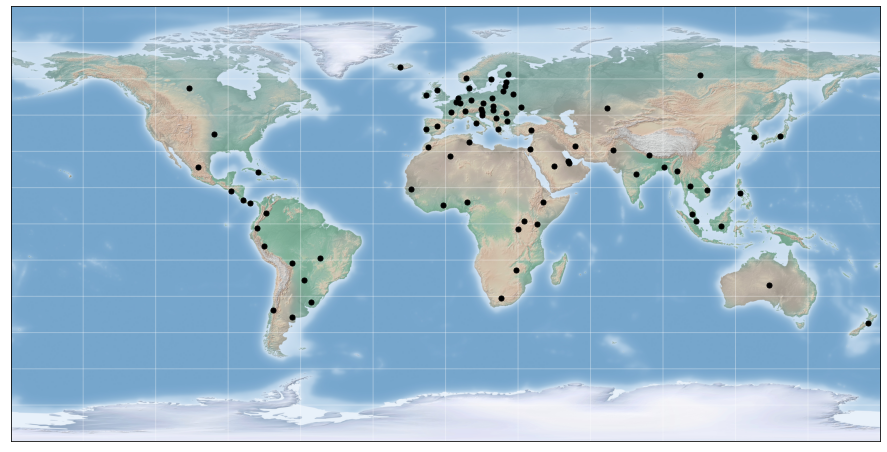

In [8]:
# Plot a world map
fig = plt.figure(figsize=(16, 8), edgecolor='w')
m = Basemap(projection='cyl', resolution=None, llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180)
draw_map(m)

# Add coordinates as points
for index, row in df.iterrows():
    x, y = m(row['Longitude'], row['Latitude'])
    plt.plot(x, y, 'ok', markersize=5)

# Number of countries by continent
df['Continent'].value_counts()

## Explode the column: Day, Tests, Cases, and Deaths

In [9]:
column = 'Day, Tests, Cases, and Deaths'

# Explode the column into multiple rows
df = df.explode(column)

# Split the column into multiple columns
df[['Date', 'Daily tests per thousand people', 'Cases', 'Deaths']] = pd.DataFrame(df[column].values.tolist(), index=df.index)
df['Date'] = df['Date'].apply(pd.to_datetime)
df = df.drop([column], axis=1)

# Preview the dataframe
df.head()

,Entity,Continent,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),Date,Daily tests per thousand people,Cases,Deaths
0,Algeria,Africa,28.03,1.66,25,1.9,1.83,4044.3,41318142,29,6,2019-12-31,NaN,0.0,0.0
0,Algeria,Africa,28.03,1.66,25,1.9,1.83,4044.3,41318142,29,6,2020-01-01,NaN,0.0,0.0
0,Algeria,Africa,28.03,1.66,25,1.9,1.83,4044.3,41318142,29,6,2020-01-02,NaN,0.0,0.0
0,Algeria,Africa,28.03,1.66,25,1.9,1.83,4044.3,41318142,29,6,2020-01-03,NaN,0.0,0.0
0,Algeria,Africa,28.03,1.66,25,1.9,1.83,4044.3,41318142,29,6,2020-01-04,NaN,0.0,0.0


# 4- Fill missing values in columns (since the first case)

In [10]:
df.isnull().sum()

Entity                                0
Continent                             0
Latitude                              0
Longitude                             0
Average temperature per year          0
Hospital beds per 1000 people         0
Medical doctors per 1000 people       0
GDP/Capita                            0
Population                            0
Median age                            0
Population aged 65 and over (%)       0
Date                                  0
Daily tests per thousand people    4102
Cases                               112
Deaths                              112
dtype: int64

In [11]:
df = df.groupby('Entity').apply(lambda x: x.fillna(method='ffill'))
df = df.groupby('Entity').apply(lambda x: x.fillna(method='bfill'))
df = df[df.Cases > 0]

# 5- Statistical description of the data

In [12]:
df.describe().round(2)

,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),Daily tests per thousand people,Cases,Deaths
count,7050.00,7050.00,7050.00,7050.00,7050.00,7050.00,7.050000e+03,7050.00,7050.00,7050.00,7050.00,7050.00
mean,27.40,21.79,15.73,3.62,2.43,27990.45,6.821411e+07,35.44,12.77,0.30,18981.17,1308.51
std,26.87,62.73,8.81,2.85,1.49,21456.90,1.721538e+08,8.06,6.72,0.48,87014.92,6016.35
min,-40.90,-106.35,-14.00,0.30,0.02,1697.71,3.412840e+05,16.00,1.00,0.00,1.00,0.00
25%,9.14,-3.44,9.00,1.60,1.11,10581.94,7.075991e+06,29.00,7.00,0.02,69.00,0.00
50%,33.89,19.50,14.00,2.70,2.54,24765.95,2.459893e+07,38.00,14.00,0.12,1111.00,15.00
75%,48.67,53.69,25.00,5.20,3.50,40585.72,6.602227e+07,42.00,19.00,0.39,7477.50,193.00
max,64.96,174.89,29.00,13.05,7.52,116935.60,1.339180e+09,48.00,28.00,4.99,1508598.00,90353.00


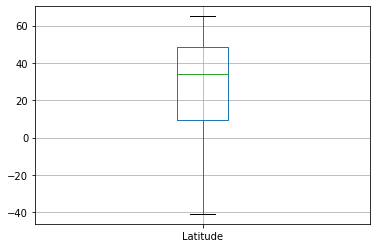

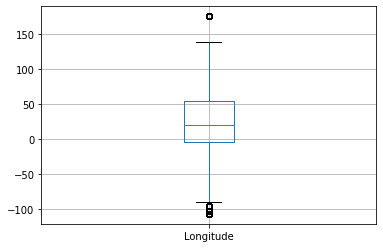

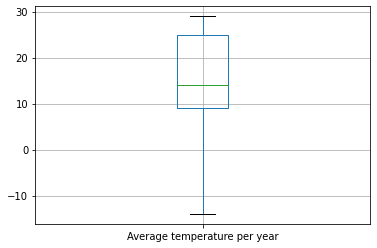

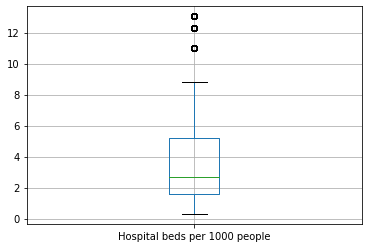

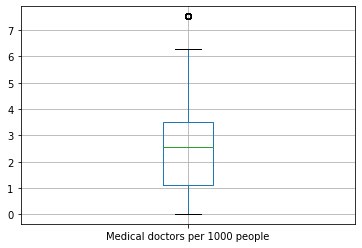

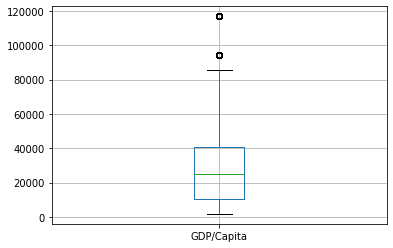

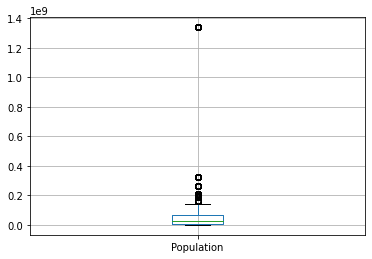

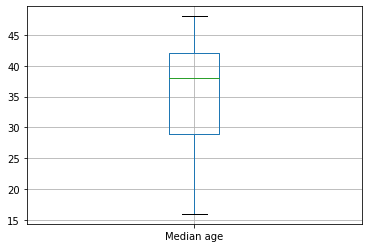

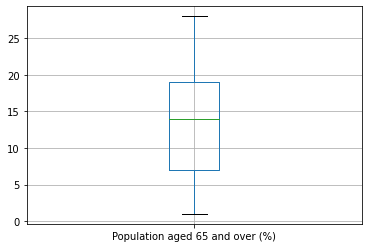

In [13]:
for column in df.drop(['Entity', 'Continent', 'Date', 'Daily tests per thousand people', 'Cases', 'Deaths'], axis=1):
    plt.figure()
    df.boxplot([column])

In [14]:
df.loc[df['Entity'] == 'Algeria'].head(1)

,Entity,Continent,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),Date,Daily tests per thousand people,Cases,Deaths
0,Algeria,Africa,28.03,1.66,25,1.9,1.83,4044.3,41318142,29,6,2020-02-26,0.005,1.0,0.0


# 6- Visualize the data

## Feature distribution with histograms

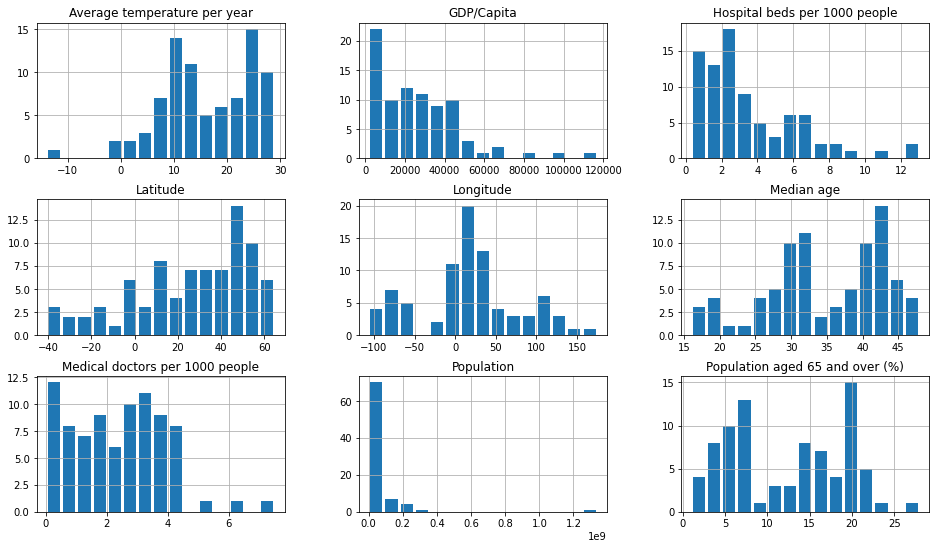

In [15]:
columns = ['Date', 'Daily tests per thousand people', 'Cases', 'Deaths']
df.drop(columns, axis=1).drop_duplicates().hist(bins=15, figsize=(16, 9), rwidth=0.8)
plt.show()

## Feature correlation with a heatmap: Last cases and deaths to date

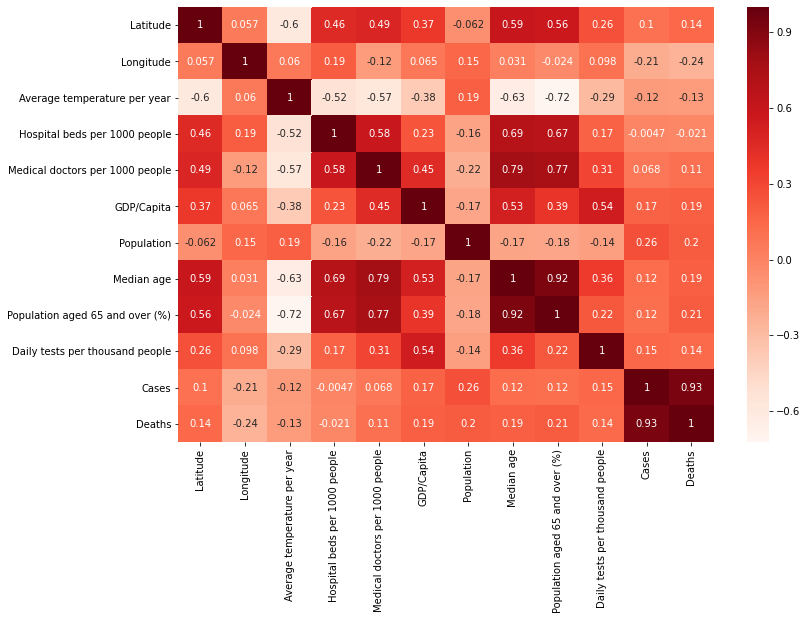

In [16]:
# Keep the last line (date) for each country and drop unused columns
df_last = df.groupby('Entity').tail(1).drop(['Entity', 'Date'], axis=1)
plt.figure(figsize=(12, 8))
sns.heatmap(df_last.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

## Output variable distributions with histograms: Last cases and deaths to date

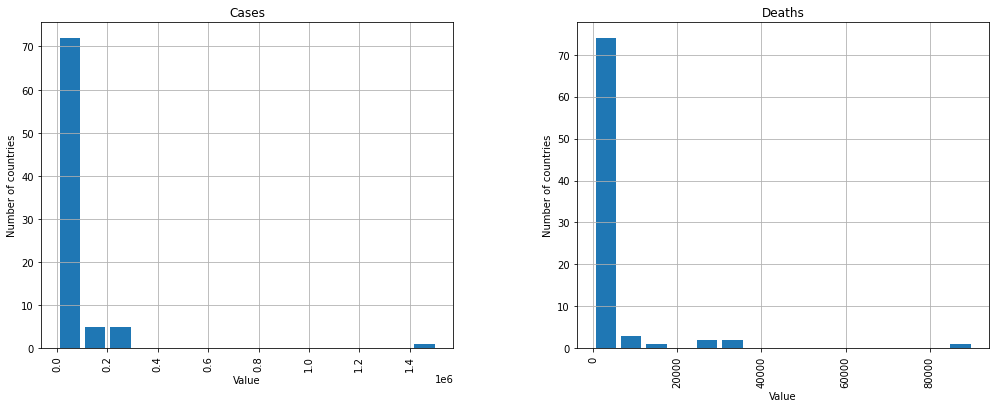

In [17]:
# Plot histograms
axarr = df_last[['Cases', 'Deaths']].hist(bins=15, figsize=(17, 6), xrot=90, sharex=False, rwidth=0.8)
for ax in axarr.flatten():
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of countries")

## Output variable curves with line plots

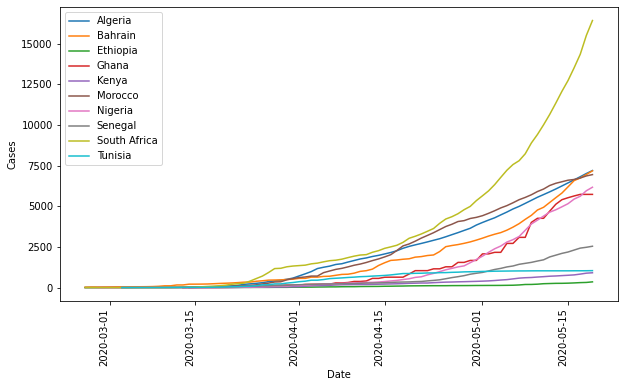

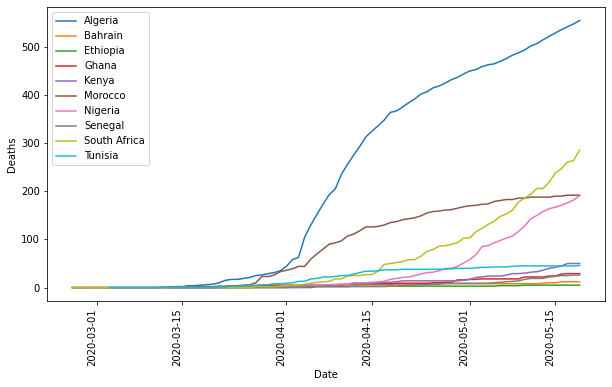

In [18]:
# Target countries and target dates
countries = ['Algeria', 'Bahrain', 'Ethiopia', 'Ghana', 'Kenya', 'Morocco', 'Nigeria', 'Senegal', 'South Africa', 'Tunisia']
df_temp = df.loc[df['Date'] > '2020-02-25']

# Plot case and death curves
for output_variable in ['Cases', 'Deaths']:
    fig, ax = plt.subplots(figsize=(10, 6))
    for key, grp in df_temp[df_temp['Entity'].isin(countries)].groupby(['Entity']):
        ax = grp.plot(ax=ax, kind='line', x='Date', y=output_variable, label=key)
    plt.legend(loc='best')
    plt.xticks(rotation=90)
    plt.ylabel(output_variable)
    plt.show()

## Feature-Output-variable distributions with scatter plots: Last cases and deaths to date

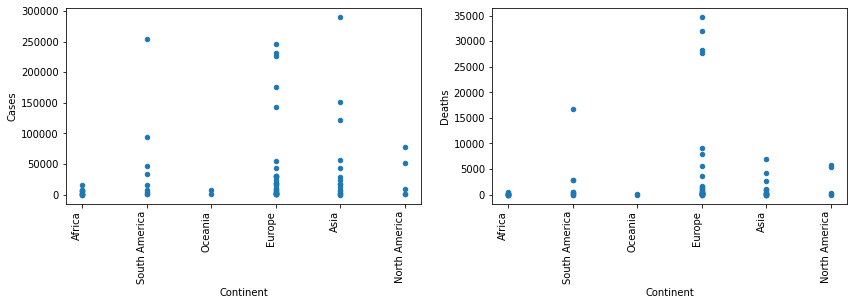

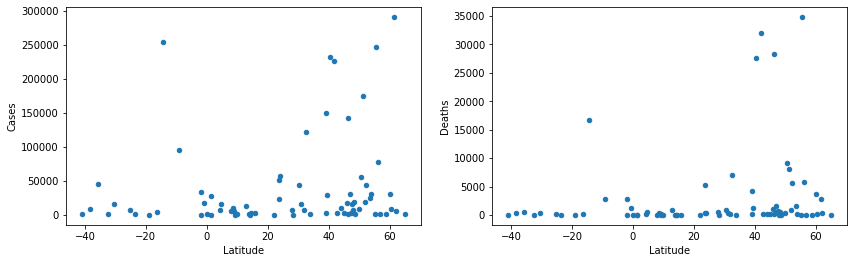

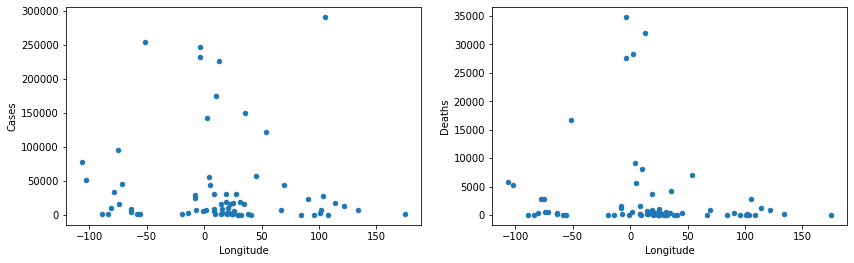

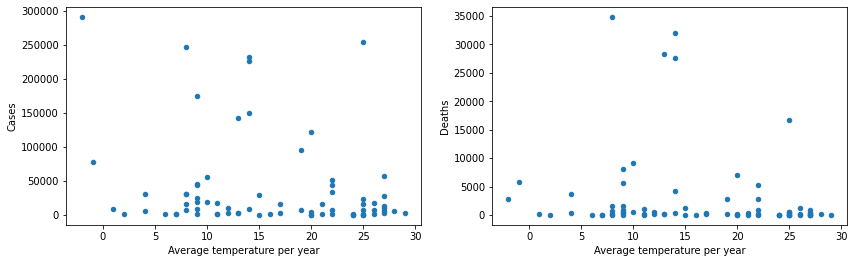

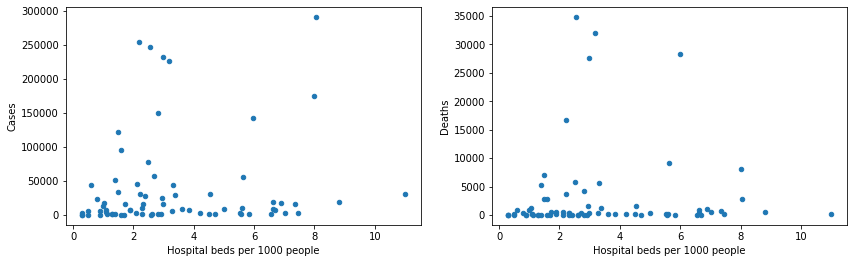

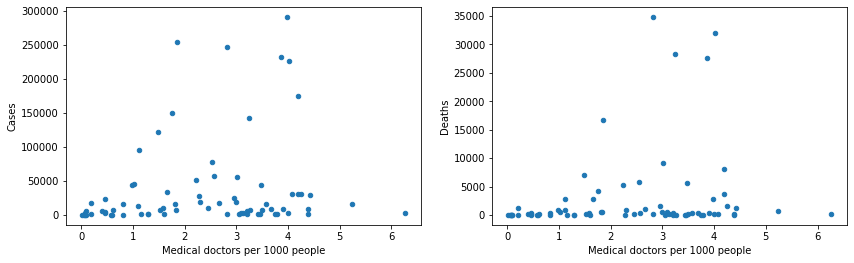

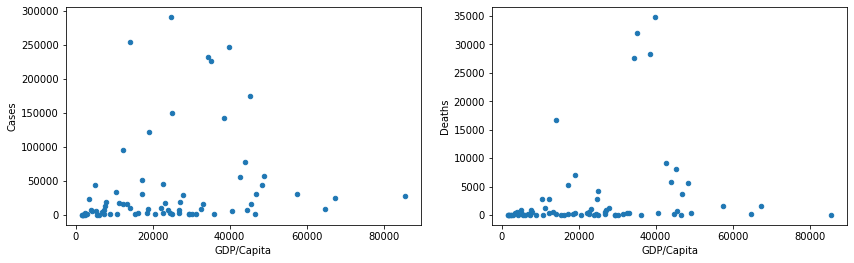

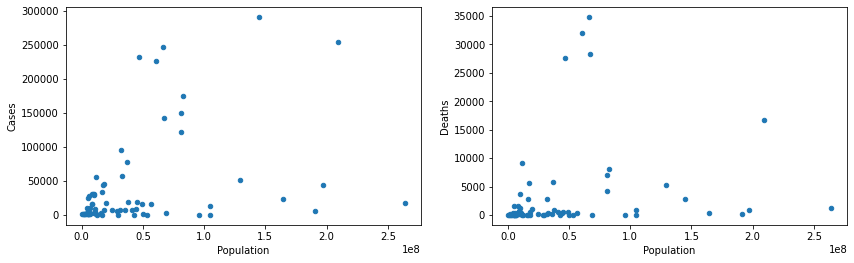

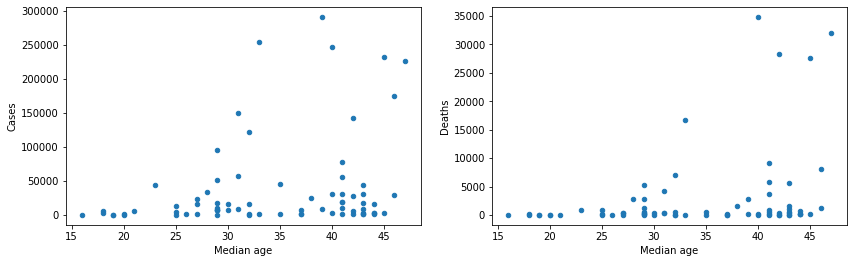

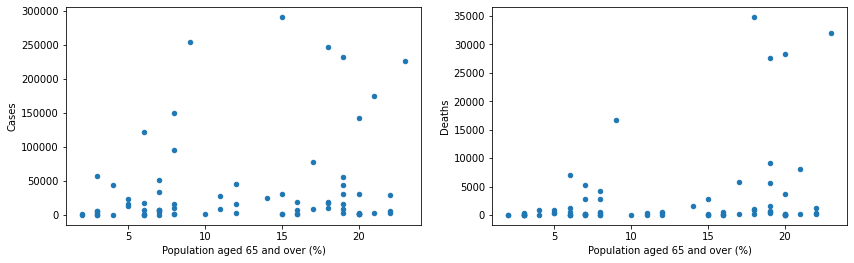

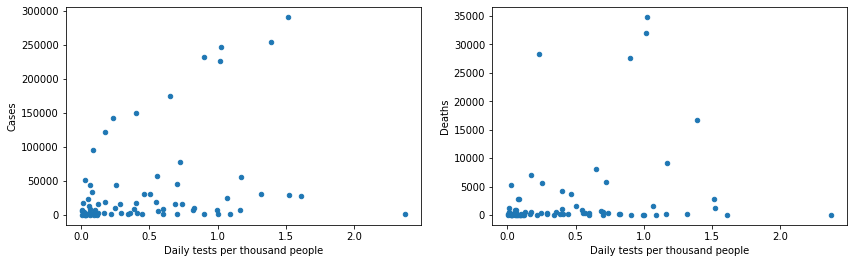

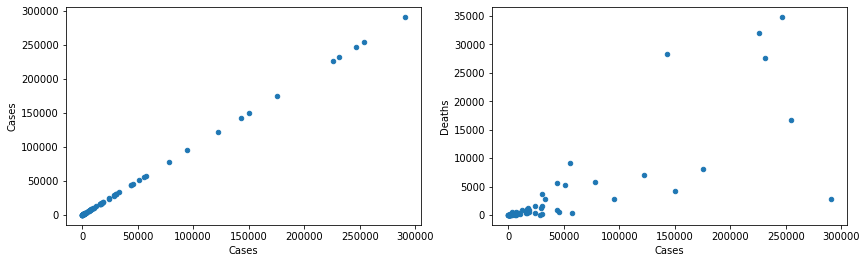

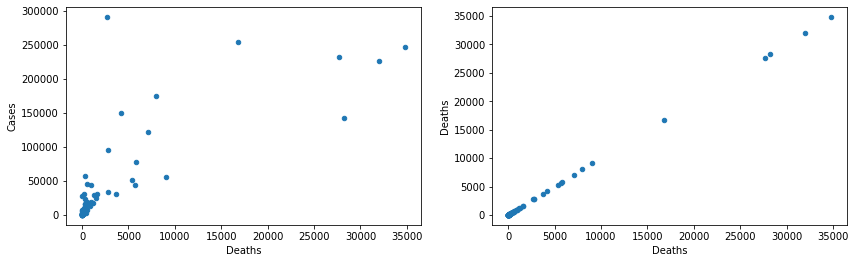

In [19]:
# Scatter plots readability: remove outliers in all comuns except in the column 'Continent'
column_continent = df_last[['Continent']]
df_last = df_last.drop('Continent', axis=1)
df_last = column_continent.join(df_last[(np.abs(zscore(df_last)) < 3).all(axis=1)])

# Plot feature-output-variable distributions for each column
for column in df_last.columns:
    fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
    df_last.plot.scatter(x=column, y='Cases', ax=ax[0])
    df_last.plot.scatter(x=column, y='Deaths', ax=ax[1])
    if column == 'Continent':
        fig.autofmt_xdate(rotation=90)

# 7- Covid forecasting: Prophet

## Select the target country and target columns

In [20]:
# Target country
df_country = df.loc[df['Entity'] == 'Algeria']

# Target columns
df_country = df_country[['Date', 'Cases', 'Deaths']]

# Set the dataframe index
df_country.index = pd.DatetimeIndex(df_country['Date'])
df_country = df_country.drop('Date', axis=1)

df_country.tail()

,Cases,Deaths
Date,,
2020-05-15,6442.0,529.0
2020-05-16,6629.0,536.0
2020-05-17,6821.0,542.0
2020-05-18,7019.0,548.0
2020-05-19,7201.0,555.0


## Output variable curves with line plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001AAAD198>,
      dtype=object)

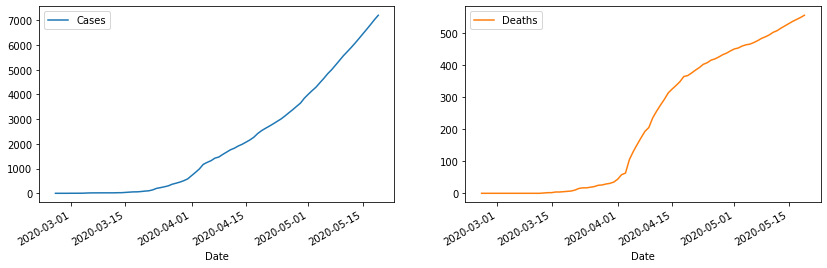

In [21]:
df_country.plot(subplots=True, layout=(1, 2), figsize=(14, 4))

## Number of daily new cases/deaths

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001B34FA20>,
      dtype=object)

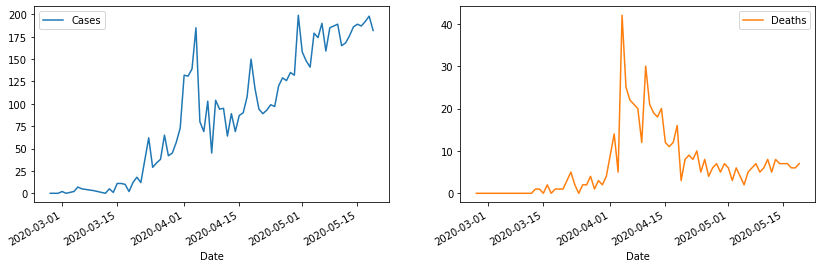

In [22]:
# Convert total number of cases/deaths to new number of cases/deaths per day
df_country_daily = df_country.copy()
df_country_daily.Cases = df_country_daily.Cases.diff(periods=1)
df_country_daily.Deaths = df_country_daily.Deaths.diff(periods=1)
df_country_daily = df_country_daily.dropna()

# Output variable curves with line plots
df_country_daily.plot(subplots=True, layout=(1, 2), figsize=(14, 4))

## Train Prophet model and make predictions

RMSE Cases: 218.87
RMSE Deaths: 4.79


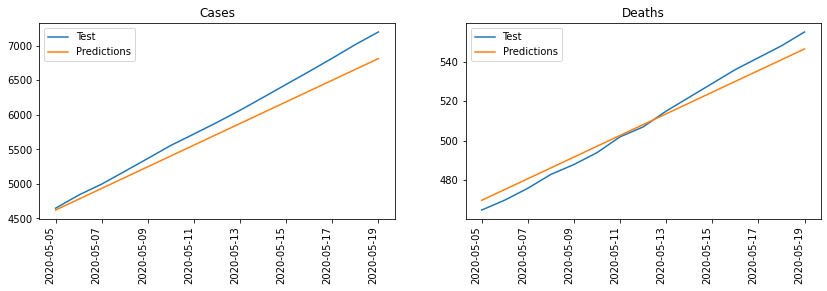

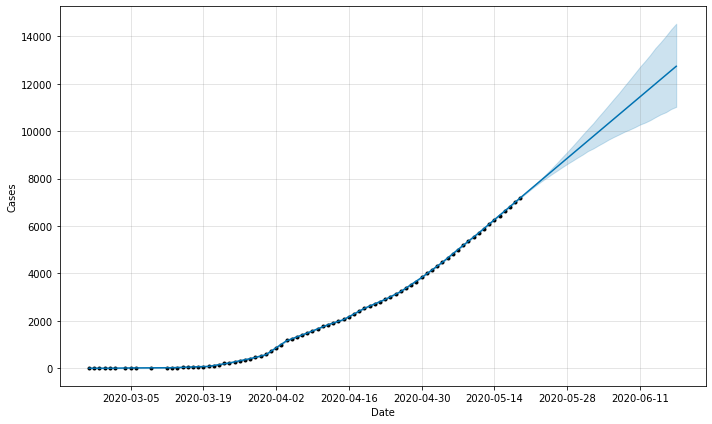

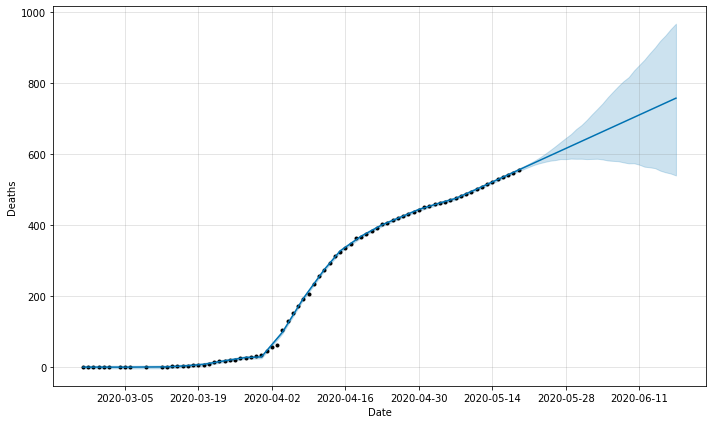

In [23]:
def initialize_model(): 
    return Prophet(changepoint_range=0.90, changepoint_prior_scale=20, n_changepoints=19, 
                   yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)


fig, ax = plt.subplots(1, 2, figsize=(14, 4))
i = 0
for output_variable in ['Cases', 'Deaths']:
    # Train and test set
    X = df_country[[output_variable]]
    X.reset_index(level=0, inplace=True)
    X.columns = ['ds', 'y']
    train, test = X[:len(X)-15], X[len(X)-15:]
    
    # Train the model
    model = initialize_model()
    model = model.fit(train)
    
    # Make predictions
    predictions = model.predict(test)
    predictions = pd.DataFrame({'Date': predictions['ds'], output_variable: predictions['yhat']})
    predictions = predictions.set_index('Date')
    test.columns = ['Date', output_variable]
    test = test.set_index('Date')

    # Plot the evaluation results
    ax[i].plot(test, label='Test')
    ax[i].plot(predictions, label='Predictions')
    ax[i].legend(loc='best')
    ax[i].set_title(output_variable)
    fig.autofmt_xdate(rotation=90)
    print ('RMSE ' + output_variable + ': ' + str(np.round(sqrt(mean_squared_error(test, predictions)), decimals=2)))
    
    # Forecast for the coming weeks
    model = initialize_model()
    model = model.fit(X)
    model.plot(model.predict(model.make_future_dataframe(periods=30)), xlabel='Date', ylabel=output_variable);
    i += 1
    
plt.show()

# 8- Feature engineering

## Convert total number of cases/deaths to number of daily new cases/deaths

In [24]:
# df.Cases = df.groupby('Entity').Cases.diff(periods=1)
# df.Deaths = df.groupby('Entity').Deaths.diff(periods=1)
# df = df.dropna()

## Onehot encoding for the column: Continent

In [25]:
df['Continent'] = pd.Categorical(df['Continent'])
dfDummies = pd.get_dummies(df['Continent'])
column_position = df.columns.get_loc('Continent')
df1 = df.iloc[:, :column_position]
df2 = df.iloc[:, column_position + 1:]
df = pd.concat([df1, dfDummies, df2], axis=1)

## Create a new column: Days since first case

In [26]:
df['Days since first case'] = df.groupby('Entity').cumcount() + 1
df_copy = df.copy()
df = df.drop(['Entity', 'Date'], axis=1)

## Remove outliers

In [27]:
df = df[(np.abs(zscore(df)) < 3).all(axis=1)]

# 9- Covid forecasting: Gradient Boosting

## Drop unused columns

In [28]:
df = df.drop(['Medical doctors per 1000 people', 'GDP/Capita', 'Africa', 'South America', 'Oceania'], axis=1)
df

,Asia,Europe,North America,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Population,Median age,Population aged 65 and over (%),Daily tests per thousand people,Cases,Deaths,Days since first case
0,0,0,0,28.03,1.66,25,1.9,41318142,29,6,0.005,1.0,0.0,1
0,0,0,0,28.03,1.66,25,1.9,41318142,29,6,0.005,1.0,0.0,2
0,0,0,0,28.03,1.66,25,1.9,41318142,29,6,0.005,1.0,0.0,3
0,0,0,0,28.03,1.66,25,1.9,41318142,29,6,0.005,1.0,0.0,4
0,0,0,0,28.03,1.66,25,1.9,41318142,29,6,0.005,3.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,0,0,0,-19.02,29.15,20,1.7,16529904,19,3,0.026,37.0,4.0,56
82,0,0,0,-19.02,29.15,20,1.7,16529904,19,3,0.026,42.0,4.0,57
82,0,0,0,-19.02,29.15,20,1.7,16529904,19,3,0.026,44.0,4.0,58
82,0,0,0,-19.02,29.15,20,1.7,16529904,19,3,0.024,46.0,4.0,59


## Train and test set

In [29]:
y = df.Cases
X = df.drop(['Cases', 'Deaths'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

## Tune overfitting/underfitting parameters with learning curves

In [30]:
def plot_learning_curve(parameter, parameter_values):
    train_results = []
    test_results = []
    
    for value in parameter_values:
        rf = GradientBoostingRegressor(**{parameter: value})
        rf.fit(X_train, y_train)
        
        train_results.append(np.round(mean_squared_error(y_train, rf.predict(X_train))))
        test_results.append(np.round(mean_squared_error(y_test, rf.predict(X_test))))
        
    line1, = plt.plot(parameter_values, train_results, color='r', label='Training Score')
    line2, = plt.plot(parameter_values, test_results, color='g', label='Testing Score')

    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('Mean Squared Error')
    plt.xlabel(parameter)
    plt.show()

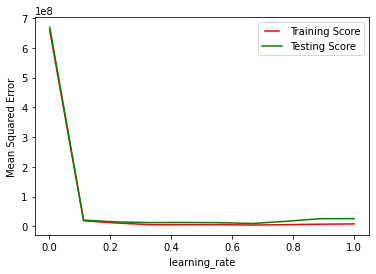

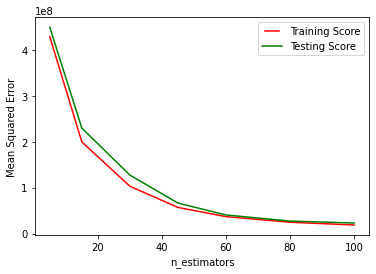

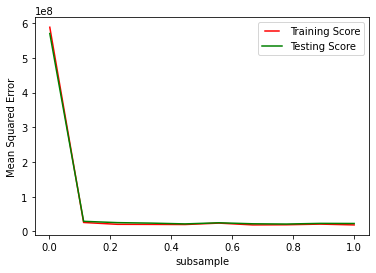

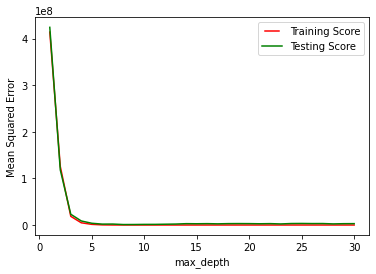

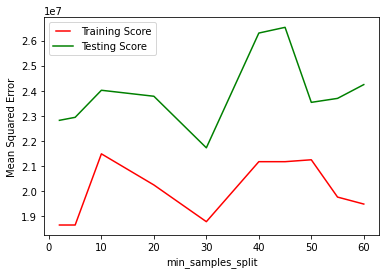

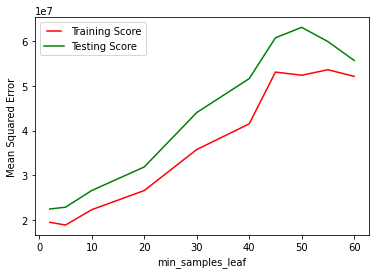

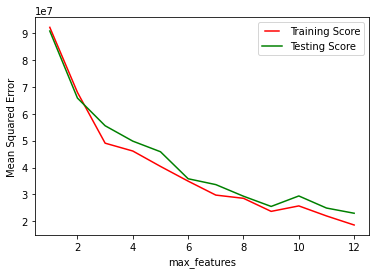

In [31]:
plot_learning_curve('learning_rate', np.linspace(0.001, 1, 10, endpoint=True))
plot_learning_curve('n_estimators', [5, 15, 30, 45, 60, 80, 100])
plot_learning_curve('subsample', np.linspace(0.001, 1, 10, endpoint=True))
plot_learning_curve('max_depth', np.linspace(1, 30, 30, endpoint=True))
plot_learning_curve('min_samples_split', [2, 5, 10, 20, 30, 40, 45, 50, 55, 60])
plot_learning_curve('min_samples_leaf', [2, 5, 10, 20, 30, 40, 45, 50, 55, 60])
plot_learning_curve('max_features', list(range(1, df.shape[1]-1)))

## Tune all parameters with RandomizedSearchCV

In [32]:
# Create a parameter distributions: map the parameter names to the values that should be searched
param_dist = {
'loss': ['ls', 'lad', 'huber', 'quantile'],
'learning_rate': [0.2],
'n_estimators': [100],
'subsample': [0.2],
'max_depth': [6],
'min_samples_split': [10, 30],
'min_samples_leaf': [10, 30],
'max_features': [6, 10]}

# Instantiate the randomized search, CV: the number of splits for the Time Series cross-validator
rand = RandomizedSearchCV(GradientBoostingRegressor(), param_dist, cv=5, scoring='neg_mean_squared_error', n_iter=32, random_state=69420)

# Fit the rand with data
rand.fit(X_train, y_train)

# Examine the best model
print(rand.best_params_)

{'subsample': 0.2, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 10, 'max_depth': 6, 'loss': 'ls', 'learning_rate': 0.2}


## Learning curve for various training set sizes

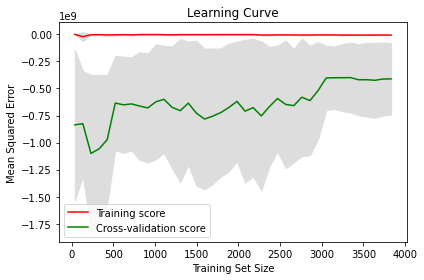

In [33]:
# Create CV training and test scores for various training set sizes (40 different sizes)
train_sizes, train_scores, test_scores = learning_curve(rand.best_estimator_, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5, scoring='neg_mean_squared_error')

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, color='r', label='Training score')
plt.plot(train_sizes, test_mean, color='g', label='Cross-validation score')

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='#DDDDDD')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='#DDDDDD')

# Create plot
plt.title('Learning Curve')
plt.xlabel('Training Set Size'), plt.ylabel('Mean Squared Error'), plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Holdout validation

RMSE: 3778.11


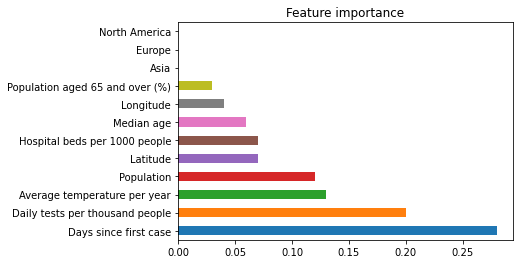

In [34]:
model = rand.best_estimator_.fit(X_train, y_train)
predictions = model.predict(X_test)
print ('RMSE: ' + str(np.round(sqrt(mean_squared_error(y_test, predictions)), decimals=2)))
feat_importances = pd.Series(np.round(model.feature_importances_, 2), index=X.columns)
colors = ["C" + str(count) for count in range(0, len(feat_importances))]
feat_importances.nlargest(20).plot(kind='barh', title='Feature importance', color=colors)

## Forecast for the coming weeks

In [35]:
# Target countries and target date
country = 'Algeria'
date_prediction = datetime.date(2020, 5, 27)

# Get the first line (date) for the target country
df_country = df_copy.loc[df_copy['Entity'] == country].iloc[0]

# Calculate the value of the column: Days since first case
df_country['Days since first case'] = (date_prediction - df_country['Date'].date()).days

# Drop unused columns
df_country = df_country[X.columns]

print(model.predict([df_country.to_numpy()]))

[12819.01549859]
